In [1]:
import os
import sys

In [2]:
#Change path_dir to your working directory
#Use only if on Colab
from google.colab import drive
drive.mount('/content/drive/')
path_dir = '/content/drive/My Drive/Etudes/Deep learning/'
os.chdir(path_dir)
sys.path.append(path_dir)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import torch
import numpy as np
import torchvision as tv
from torch import nn, optim
import pickle
from src import reliability_diagram
import matplotlib.pyplot as plt
from models import DenseNet
import torch.nn.functional as F
from src.reliability_diagram import reliability_diagram
import src.temperature_scaling
import src.platt_scaling
import src.isotonic_regression
from src.demo import demo
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score

In [4]:
# data is where data is saved
data = path_dir + 'data/'

# save is where networks are saved
save = path_dir + 'model/'

block_config = [(40 - 4) // 6 for _ in range(3)]

In [5]:
def plot_calibration(model, data, test = False, isotonic=False):
    """
    
    Parameters
    ----------
    model : nn.Module
      Calibrated (or not) model
    data : str
      path to datasets
    test : bool
      If True plots the reliability diagram obtained with the test set. Otherwise, works with the validation set 
    isotonic : bool
      True if isotonic regression was performed on the model

    Returns
    -------
      Plots the reliability diagram of the given model

    """

    # Data transforms
    mean = [0.5071, 0.4867, 0.4408]
    stdv = [0.2675, 0.2565, 0.2761]
    test_transforms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=mean, std=stdv),
    ])

    if test :
      dataset = tv.datasets.CIFAR100(data, train=False, transform=test_transforms, download=False)
      loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=64)
    else:
      valid_indices_filename = os.path.join(save, 'valid_indices.pth')
      if not os.path.exists(valid_indices_filename):
          raise RuntimeError('Cannot find file %s to load' % valid_indices_filename)
      valid_indices = torch.load(valid_indices_filename)
      dataset = tv.datasets.CIFAR100(data, train=True, transform=test_transforms, download=True)
      loader = torch.utils.data.DataLoader(dataset, pin_memory=True, batch_size=64,
                                               sampler=SubsetRandomSampler(valid_indices))

    y_true = []
    y_pred = []
    confidences = []

    for _, (input, label) in enumerate(loader):
        if isotonic:
            out_model = model(input.cuda())
        else:
            out_model = F.softmax(model(input.cuda()),1)

        prob_pred, labels_pred = torch.max(out_model,1)

        y_true += list(label.cpu().detach().numpy())
        y_pred += list(labels_pred.cpu().detach().numpy())
        confidences += list(prob_pred.cpu().detach().numpy())


    reliability_diagram(np.array(y_true), np.array(y_pred), np.array(confidences), num_bins=10,
        draw_ece=True, draw_bin_importance=True,
        draw_averages=True, title="Reliability Diagram",
        figsize=(6, 6), dpi = 72, return_fig = False)

#Calibrating models

In [6]:
demo(data, save, 'Platt', depth=40, growth_rate=12, batch_size=256)
demo(data, save, 'Temperature', depth=40, growth_rate=12, batch_size=256)
demo(data, save, 'Isotonic', depth=40, growth_rate=12, batch_size=256)

Files already downloaded and verified
Platt scaling
Before Platt - NLL: 1.943, ECE: 0.205
After Platt - NLL: 1.135, ECE: 0.014
Scaled model sved to /content/drive/My Drive/Etudes/Deep learning/model/model_with_Platt.pth
Done!
Files already downloaded and verified
Temperature
Before temperature - NLL: 1.943, ECE: 0.205
Optimal temperature: 2.735
After temperature - NLL: 1.168, ECE: 0.018
Scaled model sved to /content/drive/My Drive/Etudes/Deep learning/model/model_with_Temperature.pth
Done!
Files already downloaded and verified
Isotonic regression 1-vs-all
Before temperature - NLL: 1.943
After temperature - NLL: 1.018
Scaled model sved to /content/drive/My Drive/Etudes/Deep learning/model/model_with_Isotonic.pth
Done!


# Testing calibration on validation set

##No Calibration

In [7]:
model = DenseNet(
    growth_rate=12,
    block_config=block_config,
    num_classes=100
).cuda()

params = torch.load(save + 'model.pth')
model.load_state_dict(params)
model = model.eval()

Files already downloaded and verified


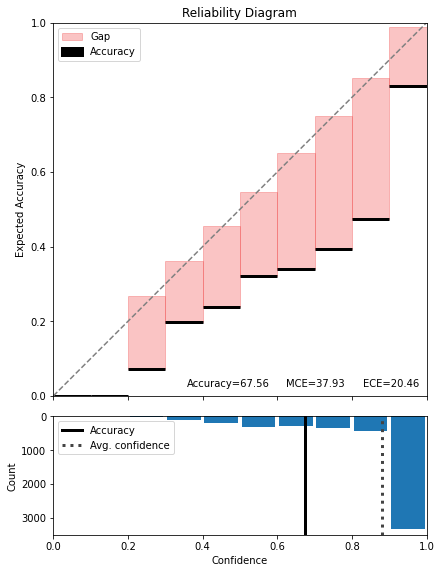

In [8]:
plot_calibration(model, data, test=False)

## Temperature scaling

In [9]:
 model_temp = DenseNet(
        growth_rate=12,
        block_config=block_config,
        num_classes=100
    )
model_temp = temperature_scaling.ModelWithTemperature(model_temp).cuda()
params = torch.load(save + 'model_with_Temperature.pth')
model_temp.load_state_dict(params)
model_temp = model_temp.eval()

Files already downloaded and verified


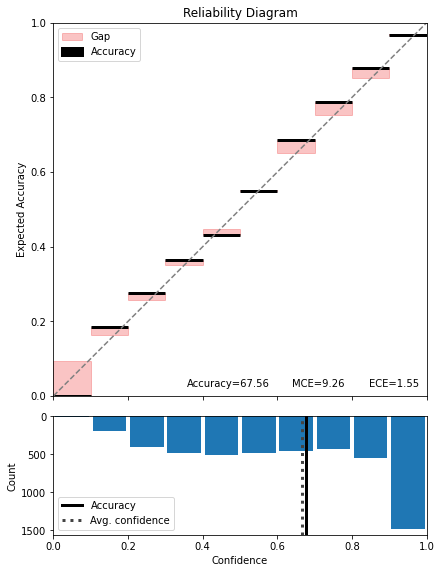

In [10]:
plot_calibration(model_temp, data, test=False)

##Platt scaling

In [11]:

model_temp = DenseNet(
  growth_rate=12,
  block_config=block_config,
  num_classes=100
)
model_temp = platt_scaling.ModelWithPlatt(model_temp).cuda()
params = torch.load(save + 'model_with_Platt.pth')
model_temp.load_state_dict(params)
model_temp = model_temp.eval()

Files already downloaded and verified


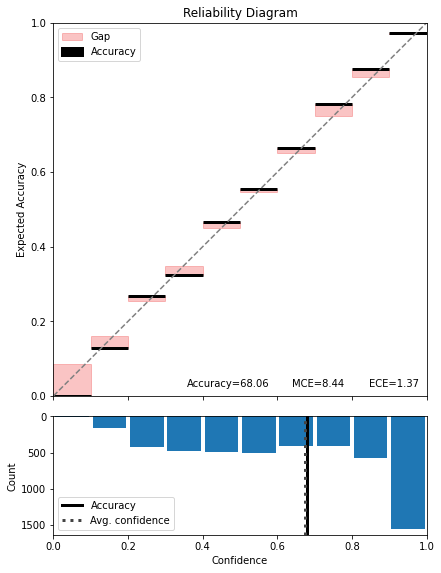

In [12]:
plot_calibration(model_temp, data, test=False)

## Isotonic regression

In [13]:
model_temp = torch.load(save + 'model_with_Isotonic.pth')
model_temp = model_temp.eval()

Files already downloaded and verified


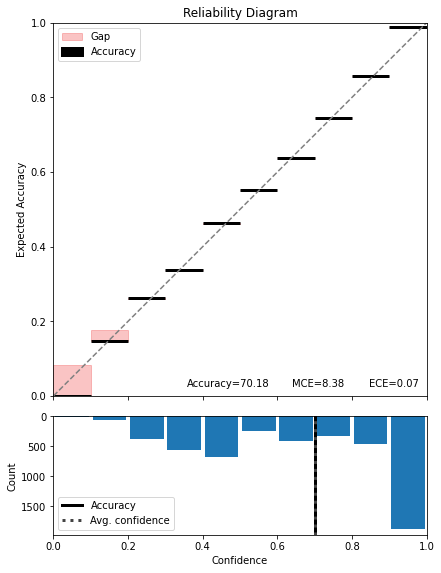

In [14]:
plot_calibration(model_temp, data, test=False, isotonic=True)

# Testing the calibration on test set

## Uncalibrated network

In [15]:
model = DenseNet(
    growth_rate=12,
    block_config=block_config,
    num_classes=100
).cuda()

params = torch.load(save + 'model.pth')
model.load_state_dict(params)
model = model.eval()

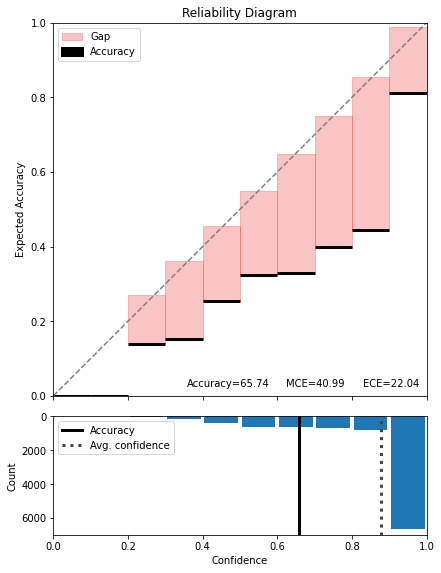

In [16]:
plot_calibration(model, data, test=True)

## Temperature scaling

In [17]:
 model_temp = DenseNet(
        growth_rate=12,
        block_config=block_config,
        num_classes=100
    )
model_temp = temperature_scaling.ModelWithTemperature(model_temp).cuda()
params = torch.load(save + 'model_with_Temperature.pth')
model_temp.load_state_dict(params)
model_temp = model_temp.eval()

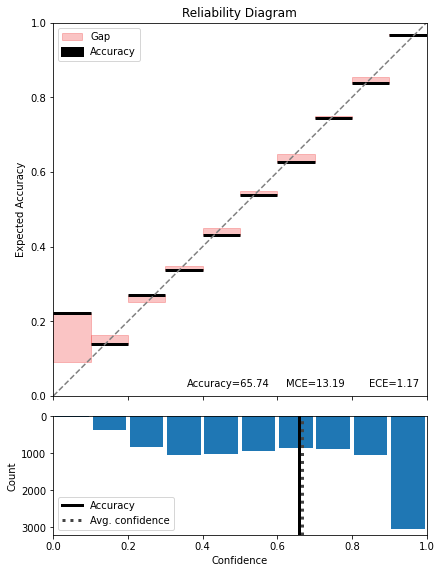

In [18]:
plot_calibration(model_temp, data, test=True)

## Platt scaling

In [19]:

model_temp = DenseNet(
  growth_rate=12,
  block_config=block_config,
  num_classes=100
)
model_temp = platt_scaling.ModelWithPlatt(model_temp).cuda()
params = torch.load(save + 'model_with_Platt.pth')
model_temp.load_state_dict(params)
model_temp = model_temp.eval()

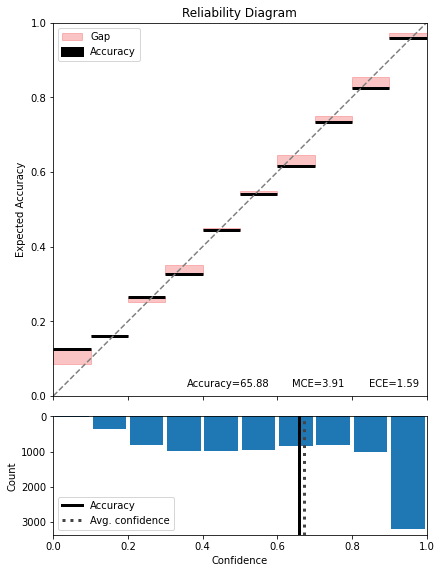

In [20]:
plot_calibration(model_temp, data, test=True)

## Isotonic regression

In [21]:
model_temp = torch.load(save + 'model_with_Isotonic.pth')
model_temp = model_temp.eval()

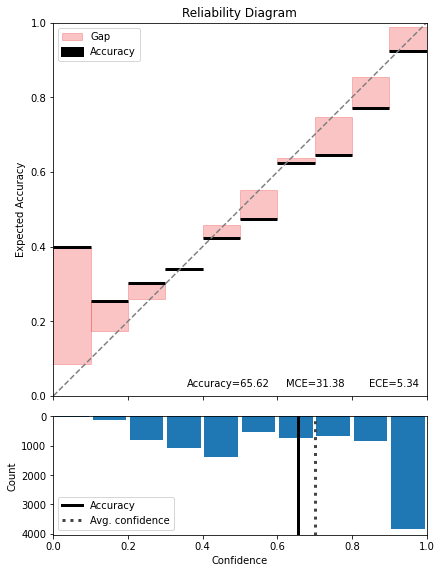

In [22]:
plot_calibration(model_temp, data, test=True, isotonic=True)